In [1]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [8]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_csv(r'..\data\processed\combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['qval_sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['qval_ogtt']
qval_cross = data['qval_sampling:ogtt']

In [3]:
# ogtt = pd.read_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv', index_col=0)
# bg = pd.read_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv', index_col=0)

In [9]:
data

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,,,,,,,,,,,,
m_0,unknown_2.353_141.06591,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,5.928611e-01,0.000031,0.620705,5.336933e-01,0.000003,0.495986,14.960875,-0.787034,0.002166,0.000655
m_1,unknown_11.539_180.0585,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,4.915771e-10,0.002260,0.000415,1.098935e-10,0.000464,0.000013,20.983077,-0.976809,-0.000127,0.001139
m_2,Urocanic acid_11.365_139.05028,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,1.835438e-01,0.751390,0.803014,1.423899e-01,0.635885,0.725216,23.336732,-0.056476,-0.000029,-0.000169
m_3,Uridine_7.513_243.06152,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,9.910100e-11,0.058097,0.495794,1.978064e-11,0.025241,0.368794,24.992686,-0.981715,-0.000293,0.000166
m_4,Uric acid_12.732_167.02007,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,4.046428e-01,0.039559,0.337231,3.470290e-01,0.015871,0.213602,29.760575,-2.837744,-0.003309,0.002223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,TG 18:0_18:0_18:0_19.885_908.86542,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,20.930734,20.351041,20.999142,...,1.127899e-02,0.001780,0.001529,6.881459e-03,0.000347,0.000134,20.216223,-2.099050,-0.000057,0.001603
l_869,unknown_20.144_948.89648,20.144,948.89648,NaN,lipid,+,unknown,19.535142,19.313450,19.774817,...,6.502325e-02,0.433296,0.001745,4.490627e-02,0.303278,0.000164,20.036803,-3.601004,-0.000961,0.002588
l_870,unknown_20.148_897.82532,20.148,897.82532,NaN,lipid,+,unknown,18.104875,18.387917,20.517490,...,6.765239e-09,0.228991,0.002301,1.791460e-09,0.133921,0.000251,20.541737,-4.135453,-0.000509,0.001666


In [10]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_params(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_222', data)
test

{'RBG': [[846.75, 2321.25], [22.853672845895826, 23.492035670589082]],
 'FBG': [[846.75, 2321.25], [20.93911947721862, 20.748523890911382]]}

In [95]:
subset

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,,,,,,,,,,,,
l_129,PC 18:2_20:5_7.636_804.55408,7.636,804.55408,NaN,lipid,+,PC 18:2_20:5,22.914276,22.111414,19.990062,...,1.060534e-17,0.987580,0.013099,6.421065e-19,9.751766e-01,0.003050,21.271274,0.298092,-0.000402,0.000813
l_143,PC 18:3_18:2_7.745_838.56165,7.745,838.56165,NaN,lipid,-,PC 18:3_18:2,21.337651,20.319677,19.315666,...,3.176324e-19,0.157430,0.039326,1.458193e-20,8.369048e-02,0.013266,19.581523,0.511086,-0.000079,0.000508
l_150,PC 38:7_7.784_804.55353,7.784,804.55353,NaN,lipid,+,PC 38:7,22.342730,22.257463,21.670660,...,7.915088e-06,0.102908,0.011834,3.159716e-06,4.977653e-02,0.002614,21.073125,1.894448,0.000144,-0.000792
l_159,SM d36:3_7.927_727.57532,7.927,727.57532,NaN,lipid,+,SM d36:3,19.744557,19.926139,20.096682,...,6.925562e-04,0.000541,0.041750,3.474301e-04,8.236025e-05,0.014167,20.311751,-0.851339,0.000124,0.000366
l_199,PC 18:2_18:2_8.239_782.56964,8.239,782.56964,NaN,lipid,+,PC 18:2_18:2,27.897746,27.291519,24.681446,...,3.243312e-23,0.330510,0.026450,4.747364e-25,2.148425e-01,0.007919,25.584962,1.146826,-0.000218,0.000801
l_231,Plasmanyl-PC O-34:3_8.546_742.57703,8.546,742.57703,NaN,lipid,+,Plasmanyl-PC O-34:3,22.538168,21.480510,18.212993,...,3.139279e-20,0.804684,0.022596,1.200867e-21,7.090843e-01,0.006374,19.642423,0.997719,-0.000489,0.001126
l_245,PC O-36:3_8.667_768.58948,8.667,768.58948,NaN,lipid,+,PC O-36:3,22.798333,21.786827,20.235826,...,2.463499e-14,0.133648,0.015538,2.671659e-15,6.891371e-02,0.003856,21.202528,0.027211,-0.000131,0.000680
l_260,Plasmenyl-PE P-18:1_22:6_8.781_772.52948,8.781,772.52948,NaN,lipid,-,Plasmenyl-PE P-18:1_22:6,21.713557,19.636974,17.882242,...,2.594201e-09,0.000081,0.002062,6.459773e-10,7.940104e-06,0.000215,18.887443,-1.298112,0.000210,0.001726
l_267,Plasmenyl-PE P-38:6_8.843_746.51434,8.843,746.51434,NaN,lipid,-,Plasmenyl-PE P-38:6,23.536941,22.675744,21.783669,...,7.626684e-09,0.029260,0.018013,2.044946e-09,1.115504e-02,0.004688,22.434769,-0.481194,-0.000053,0.000965


In [74]:
subset.sort_values('qval_sampling:ogtt').iloc[0].name

'l_546'

In [101]:
def pval_text(pval):
    if pval < 0.001:
        return '< 0.001'
    elif pval < 0.01:
        return '< 0.01'
#     elif pval < 0.05:
    else:
        return f'= {round(pval, 3)}'

(0.0, 1.0)

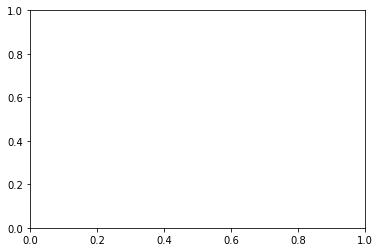

In [110]:
plt.ylim()

In [119]:
df

1101_8_FBG     24.129436
1101_9_FBG     24.701856
1101_10_FBG    24.669806
Name: m_123, dtype: object

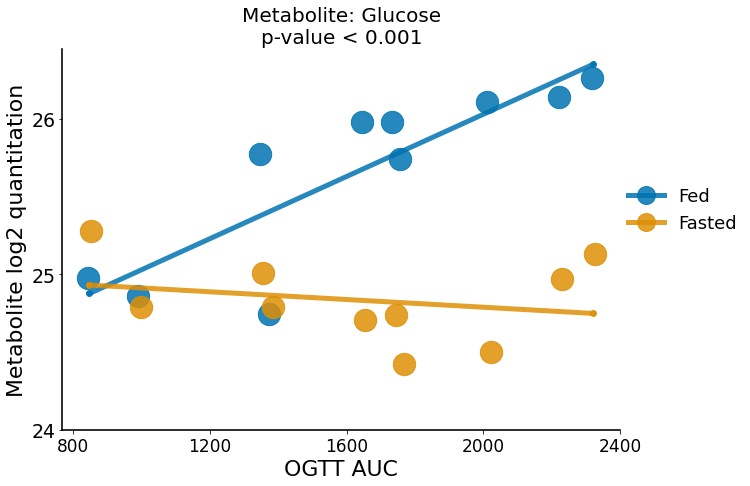

In [169]:
#### animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
subset = data.loc[
    (~data['unique_id'].str.contains('unknown')) & \
#     (data['Type'] == 'lipid') & \
    (data['Type'] == 'metabolite') & \
#     (data['molec_class'] != 'TG') & \
    (data['qval_ogtt'] < 0.05) & \
    (data['qval_sampling:ogtt'] < 0.05)
]
# feature = data.loc[(~data['unique_id'].str.contains('unknown')) & (data['Type'] == 'lipid')]\
#               .sort_values('qval_sampling:ogtt').iloc[0].name
feature = 'm_123'  # m_123 = Glucose
# feature = subset.sort_values('qval_sampling:ogtt').iloc[0].name

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
fig.set_facecolor('white')
params = get_model_params(feature, data)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    label = ('Fed' if bg_type == 'RBG' else 'Fasted')
    ax.plot(params[bg_type][0], params[bg_type][1], color=bg_color,
            linewidth=5, alpha=0.85, label=label)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
#         plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85, s=200)
        plt.scatter(np.array([animal_ogtt]*1) + offset, df.mean(), color=bg_color, alpha=0.85, s=500)
plt.ylabel('Metabolite log2 quantitation', fontsize=22)
plt.yticks(range(round(plt.ylim()[0]), round(plt.ylim()[1])+1), fontsize=19)
plt.xlabel('OGTT AUC', fontsize=22)  # \nOral Glucose Tolerance Test Area Under Curve
plt.xticks(range(800, 2500, 400), fontsize=17)

interaction_pval = pval_text(data.loc[feature, qval_cross.name])
ogtt_pval = pval_text(data.loc[feature, qval_gtol.name])
# feature_pvalue = round(data.loc[feature, qval_cross.name], 3)
plt.title('Metabolite: ' + str(data.loc[feature, 'ID']) + \
#           f'\ninteraction term p-value {interaction_pval}' + \
#           f'\nglucose tolerance p-value {ogtt_pval}'
          f'\np-value {interaction_pval}', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
handles = [x.set_marker('o') for x in handles]
plt.legend(loc=(1, 0.5), fontsize=18, markerscale=3, frameon=False)
# for ogtt_value in animal_ogtts.iloc[:, 0]:
#     plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
sns.despine()
[x.set_linewidth(1.6) for x in ax.spines.values()];  # Set width of Spines 
plt.savefig(r'..\reports\figures\3-5-0\glucose.svg', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(r'..\reports\figures\3-5-0\glucose.png', dpi=300, bbox_inches='tight', facecolor='white')

In [37]:
data.loc['m_135'].filter(regex='model_param')

model_param_Intercept               15.004706
model_param_sampling[T.RBG]         -2.082508
model_param_week[T.8]                 1.50305
model_param_week[T.9]                0.462843
model_param_litter[T.1]              0.668387
model_param_litter[T.2]              0.879926
model_param_litter[T.3]             -0.538849
model_param_ogtt                     0.001357
model_param_sampling[T.RBG]:ogtt     0.000132
model_param_insulin                 -0.002342
model_param_weight                   0.050261
Name: m_135, dtype: object

Good metablites with small p-val in cross

5: lactic acid
6: Threonine
9: Threonine

In [26]:
round(data.loc[feature, qval_cross.name], 4)

0.0097

trans-Petroselinic acid_281.24793_1.568
m_3


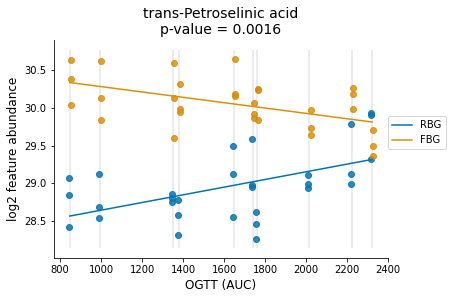

In [48]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_cross.name).iloc[2] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_cross.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

Lysine_147.11289_17.689
m_234


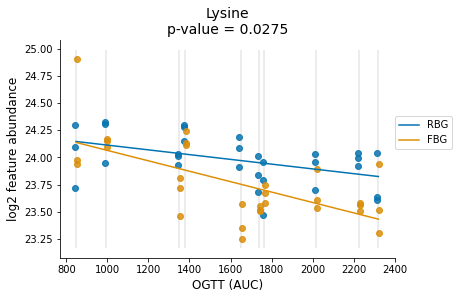

In [67]:


animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_gtol.name).iloc[10] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_gtol.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

In [6]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 
d

{'RBG': {1091: i
  l_0      23.966487
  l_1      24.912942
  l_2      23.413989
  l_3      27.350338
  l_4      22.522382
             ...    
  m_169    25.124559
  m_213    23.324871
  m_24     27.744507
  m_505    21.655395
  m_441    22.617104
  Length: 1727, dtype: float64,
  1093: i
  l_0      23.611918
  l_1      24.567604
  l_2      23.952991
  l_3      26.970232
  l_4      22.766641
             ...    
  m_169    25.198418
  m_213    22.464199
  m_24     27.636194
  m_505    21.183386
  m_441    22.558525
  Length: 1727, dtype: float64,
  1060: i
  l_0      23.840615
  l_1      25.054730
  l_2      24.048209
  l_3      26.942758
  l_4      23.111682
             ...    
  m_169    24.832177
  m_213    21.665979
  m_24     27.396343
  m_505    20.623551
  m_441    22.525861
  Length: 1727, dtype: float64,
  1062: i
  l_0      23.174288
  l_1      23.608273
  l_2      23.749417
  l_3      27.198735
  l_4      22.836285
             ...    
  m_169    24.855207
  m_213    23.623

In [7]:
feature = 'l_557'
test = get_model_fits(feature, ogtt)

plt.plot(test['RBG'][0], test['RBG'][1], c=colors['RBG'], label='random-fed')
plt.plot(test['FBG'][0], test['FBG'][1], c=colors['FBG'], label='fasted')


for bg_type in ['RBG', 'FBG']:
    for animal in animals_used:
        plt.scatter()
    

plt.scatter()

plt.legend()

NameError: name 'get_model_fits' is not defined